# 🏍️ **MotoGP Lap Time Prediction**
*This notebook presents a clean machine learning pipeline for predicting MotoGP lap times using engineered features and boosting models.  
We explore the data, build features, implement models, and generate a submission file.*


In [1]:
!pip install -q opendatasets

***Kaggle Details:***
{"username":"docku***", "key":"be08cfb8e6636e7e*******"}

*# Note use your username and key*

In [2]:
# Importing data from kaggle
import opendatasets as od
od.download("https://www.kaggle.com/competitions/burnout-datathon-ieeecsmuj/overview")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dockumar
Your Kaggle Key: ··········


100%|██████████| 210M/210M [00:00<00:00, 621MB/s]



Extracting archive ./burnout-datathon-ieeecsmuj/burnout-datathon-ieeecsmuj.zip to ./burnout-datathon-ieeecsmuj


 ***Import libraries***

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

***Loading the data***

In [18]:
df = pd.read_csv('/content/burnout-datathon-ieeecsmuj/train.csv')

# **Basic Overview of Data**

In [19]:
df.head()

,Unique ID,Rider_ID,category_x,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Track_Condition,Humidity_%,Tire_Compound_Front,...,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
0,1894944,2659,Moto2,4.874,22,17,264.66,Wet,61,Hard,...,23,35,53,45,41,4,0,2018,2021,4
1,23438,5205,Moto2,3.875,24,7,177.56,Wet,77,Soft,...,12,12,27,27,22,2,1,1975,1983,8
2,939678,7392,Moto3,5.647,25,5,317.74,Dry,87,Soft,...,22,23,45,43,10,0,0,1982,1989,8
3,1196312,7894,Moto3,4.810,19,3,321.82,Wet,43,Soft,...,23,35,192,172,155,16,9,1994,2009,16
4,1033899,6163,MotoGP,5.809,25,21,239.92,Wet,47,Hard,...,22,31,175,146,132,29,17,2011,2021,11


In [20]:
# Checking the shape
df.shape

(1914056, 45)

In [21]:
# Checking the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914056 entries, 0 to 1914055
Data columns (total 45 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Unique ID                        int64  
 1   Rider_ID                         int64  
 2   category_x                       object 
 3   Circuit_Length_km                float64
 4   Laps                             int64  
 5   Grid_Position                    int64  
 6   Avg_Speed_kmh                    float64
 7   Track_Condition                  object 
 8   Humidity_%                       int64  
 9   Tire_Compound_Front              object 
 10  Tire_Compound_Rear               object 
 11  Penalty                          object 
 12  Championship_Points              int64  
 13  Championship_Position            int64  
 14  Session                          object 
 15  year_x                           int64  
 16  sequence                         int64  
 17  rider   

In [22]:
# checking stats property
df.describe()

,Unique ID,Rider_ID,Circuit_Length_km,Laps,Grid_Position,Avg_Speed_kmh,Humidity_%,Championship_Points,Championship_Position,year_x,...,air,ground,starts,finishes,with_points,podiums,wins,min_year,max_year,years_active
count,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,...,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06,1.914056e+06
mean,1.367777e+06,5.509394e+03,4.701208e+00,2.150189e+01,1.149819e+01,2.496328e+02,5.951643e+01,1.744615e+02,1.254921e+01,1.997913e+03,...,2.190190e+01,2.973457e+01,1.012372e+02,8.746167e+01,7.096455e+01,1.399721e+01,7.374099e+00,1.993047e+03,2.002509e+03,9.377671e+00
std,7.890630e+05,2.597186e+03,6.910968e-01,2.293772e+00,6.334418e+00,5.773525e+01,1.733707e+01,1.009485e+02,6.913828e+00,1.708566e+01,...,5.928275e+00,1.162753e+01,8.143524e+01,6.986620e+01,6.685675e+01,2.615523e+01,1.641622e+01,1.683261e+01,1.747976e+01,5.144729e+00
min,0.000000e+00,1.000000e+03,3.500000e+00,1.800000e+01,1.000000e+00,1.500000e+02,3.000000e+01,0.000000e+00,1.000000e+00,1.949000e+03,...,1.200000e+01,1.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.949000e+03,1.949000e+03,1.000000e+00
25%,6.847348e+05,3.258000e+03,4.104000e+00,1.900000e+01,6.000000e+00,1.993500e+02,4.400000e+01,8.700000e+01,7.000000e+00,1.987000e+03,...,1.700000e+01,2.100000e+01,3.500000e+01,3.100000e+01,1.700000e+01,0.000000e+00,0.000000e+00,1.983000e+03,1.991000e+03,5.000000e+00
50%,1.368276e+06,5.514000e+03,4.702000e+00,2.200000e+01,1.200000e+01,2.496500e+02,6.000000e+01,1.740000e+02,1.300000e+01,2.001000e+03,...,2.100000e+01,2.900000e+01,8.500000e+01,7.400000e+01,5.300000e+01,4.000000e+00,1.000000e+00,1.996000e+03,2.007000e+03,9.000000e+00
75%,2.050815e+06,7.760000e+03,5.299000e+00,2.400000e+01,1.700000e+01,2.994600e+02,7.500000e+01,2.620000e+02,1.900000e+01,2.012000e+03,...,2.600000e+01,4.000000e+01,1.460000e+02,1.230000e+02,1.060000e+02,1.600000e+01,7.000000e+00,2.006000e+03,2.019000e+03,1.200000e+01
max,2.734366e+06,9.998000e+03,5.900000e+00,2.500000e+01,2.200000e+01,3.500000e+02,8.900000e+01,3.490000e+02,2.400000e+01,2.021000e+03,...,3.600000e+01,5.400000e+01,4.060000e+02,3.730000e+02,3.650000e+02,1.780000e+02,1.180000e+02,2.021000e+03,2.021000e+03,2.600000e+01


In [23]:
# Checking for missing values
df.isnull().sum()

,0
Unique ID,0
Rider_ID,0
category_x,0
Circuit_Length_km,0
Laps,0
Grid_Position,0
Avg_Speed_kmh,0
Track_Condition,0
Humidity_%,0
Tire_Compound_Front,0


***Only Penalty	have 321292 null rows***

In [24]:
# Checking the variation in penality column
df['Penalty'].unique()

array(['+3s', '+5s', 'DNF', 'DNS', 'Ride Through', nan], dtype=object)

In [25]:
# Filling the penality vlaue
df['Penalty'].fillna("No_Penalty", inplace=True)

# **Feature Engineering**

In [26]:
# Checking unique values for objects columns
print("Tire Front:", df["Tire_Compound_Front"].unique())
print("Tire Rear:", df["Tire_Compound_Rear"].unique())
print("Weather:", df["weather"].unique())
print("Track Condition:", df["Track_Condition"].unique())
print("Bike Name:", df["bike_name"].nunique(), "unique bikes")
print("Team Name:", df["team_name"].nunique(), "unique teams")

Tire Front: ['Hard' 'Soft' 'Medium']
Tire Rear: ['Hard' 'Medium' 'Soft']
Weather: ['Clear' 'Raining' 'Cloudy' 'Partly cloudy' 'Sunny']
Track Condition: ['Wet' 'Dry']
Bike Name: 301 unique bikes
Team Name: 967 unique teams


In [27]:
# Binary Flags for Penality Column
df["Penalty_Has_Time"] = df["Penalty"].isin(["+3s", "+5s"]).astype(int)
df["Penalty_RideThrough"] = (df["Penalty"] == "Ride Through").astype(int)
df["Penalty_DNF_DNS"] = df["Penalty"].isin(["DNF", "DNS"]).astype(int)

In [28]:
# Mapping Tire Front and Tire Rear
tire_map = {'Hard': 1, 'Medium': 2, 'Soft': 3}
df['Tire_Compound_Front_Num'] = df['Tire_Compound_Front'].map(tire_map)
df['Tire_Compound_Rear_Num'] = df['Tire_Compound_Rear'].map(tire_map)

In [29]:
# Track condition: binary
df['Is_Wet_Track'] = (df['Track_Condition'] == 'Wet').astype(int)

In [30]:
# Weather: map to numeric risk
weather_map = {'Raining': 3, 'Cloudy': 2, 'Partly cloudy': 1, 'Clear': 0, 'Sunny': 0}
df['Weather_Risk'] = df['weather'].map(weather_map)

In [31]:
# New columns for bad weather
df['Is_Bad_Weather'] = ((df['Weather_Risk'] >= 2) | (df['Is_Wet_Track'] == 1)).astype(int)

In [32]:
# Encoding Bike name and Team name
bike_target = df.groupby('bike_name')['Lap_Time_Seconds'].mean().to_dict()
df['Bike_Target_Lap'] = df['bike_name'].map(bike_target)

team_target = df.groupby('team_name')['Lap_Time_Seconds'].mean().to_dict()
df['Team_Target_Lap'] = df['team_name'].map(team_target)

In [33]:
# Advance feature engineering

df['Total_Pit_Time'] = df['Pit_Stop_Duration_Seconds'] * df['Laps']
df['Temperature_Gradient'] = df['Track_Temperature_Celsius'] - df['Ambient_Temperature_Celsius']
df['Tire_Wear_Score'] = df['Tire_Degradation_Factor_per_Lap'] * df['Laps']

# **Exploratory Data Analysis**

In [41]:
df.columns

Index(['Unique ID', 'Rider_ID', 'category_x', 'Circuit_Length_km', 'Laps',
       'Grid_Position', 'Avg_Speed_kmh', 'Track_Condition', 'Humidity_%',
       'Tire_Compound_Front', 'Tire_Compound_Rear', 'Penalty',
       'Championship_Points', 'Championship_Position', 'Session', 'year_x',
       'sequence', 'rider', 'team', 'bike', 'position', 'points', 'shortname',
       'circuit_name', 'rider_name', 'team_name', 'bike_name',
       'Lap_Time_Seconds', 'Corners_per_Lap',
       'Tire_Degradation_Factor_per_Lap', 'Pit_Stop_Duration_Seconds',
       'Ambient_Temperature_Celsius', 'Track_Temperature_Celsius', 'weather',
       'track', 'air', 'ground', 'starts', 'finishes', 'with_points',
       'podiums', 'wins', 'min_year', 'max_year', 'years_active',
       'Penalty_Has_Time', 'Penalty_RideThrough', 'Penalty_DNF_DNS',
       'Tire_Compound_Front_Num', 'Tire_Compound_Rear_Num', 'Is_Wet_Track',
       'Weather_Risk', 'Is_Bad_Weather', 'Bike_Target_Lap', 'Team_Target_Lap',
       'Total_P

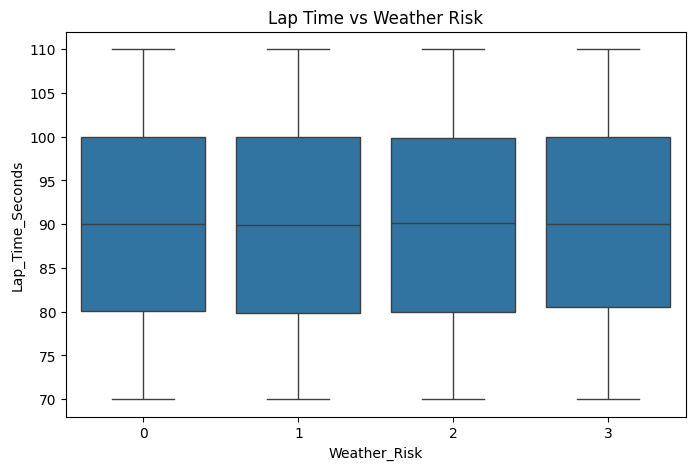

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Weather_Risk', y='Lap_Time_Seconds', data=df)
plt.title("Lap Time vs Weather Risk")
plt.show()

*Here, it can be seen that lap time appears to be fairly consistent across all the weathers.*

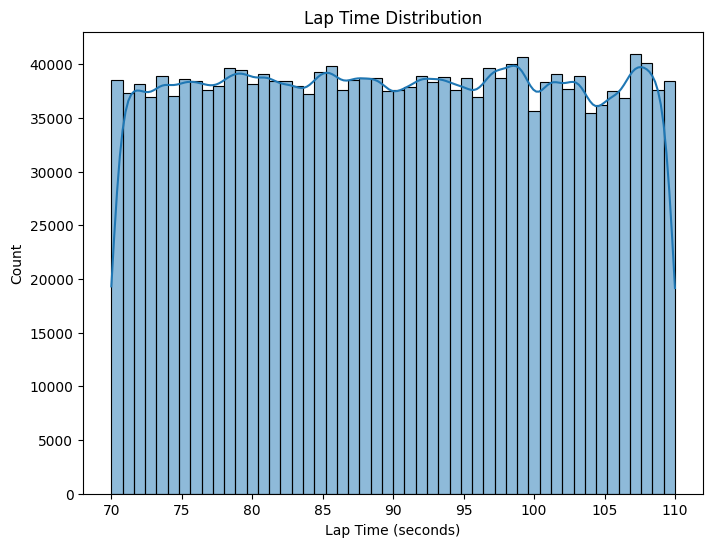

In [42]:
plt.figure(figsize=(8,6))
sns.histplot(df['Lap_Time_Seconds'], bins=50, kde=True)
plt.title('Lap Time Distribution')
plt.xlabel('Lap Time (seconds)')
plt.show()


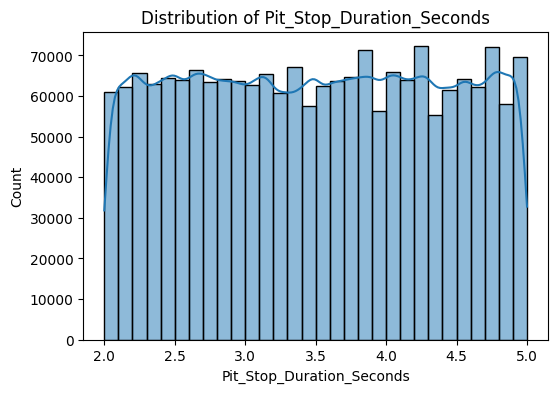

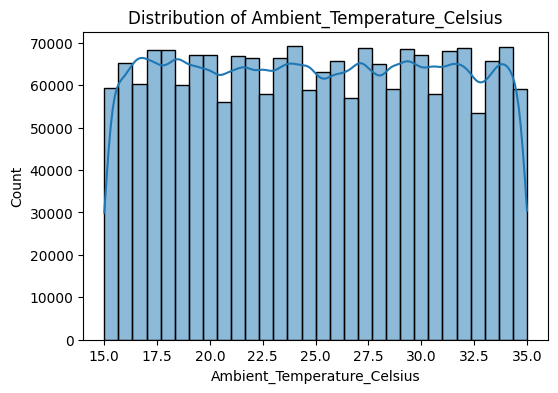

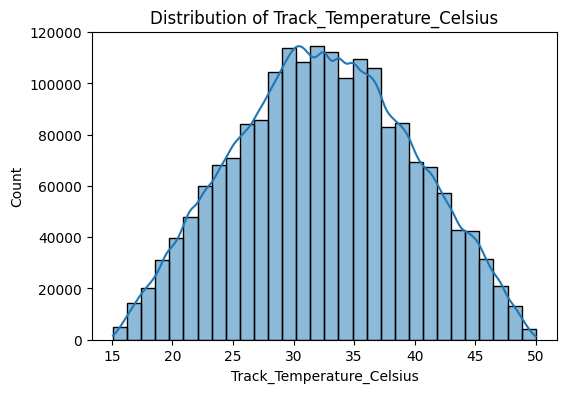

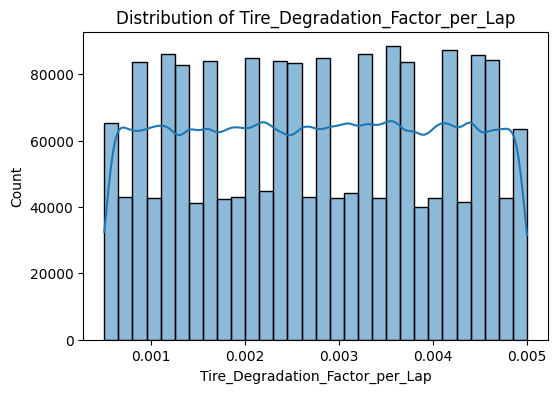

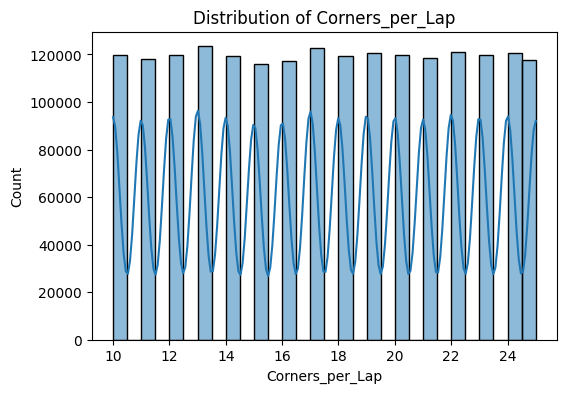

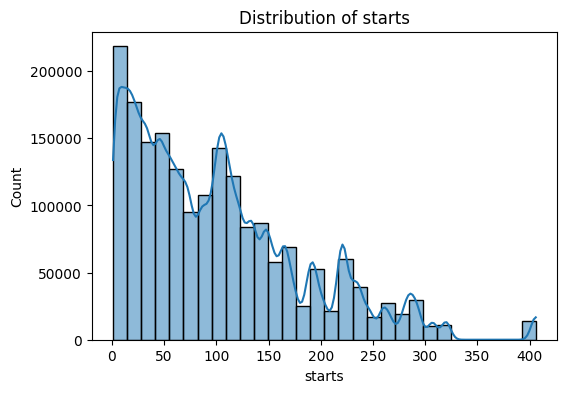

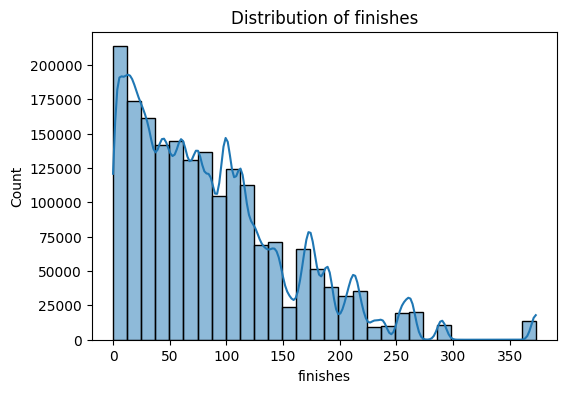

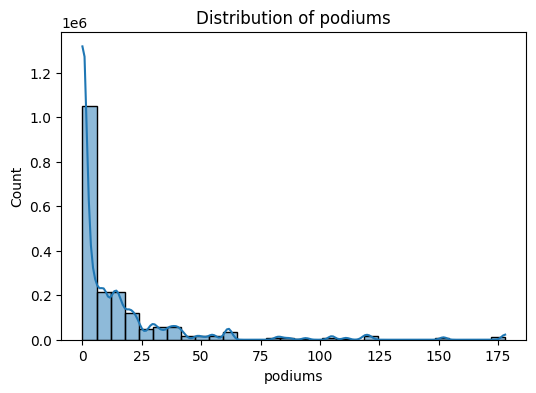

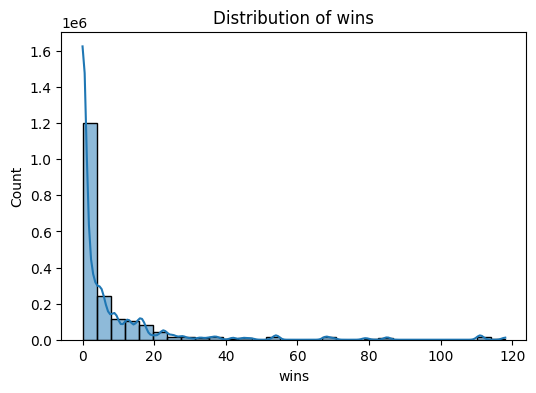

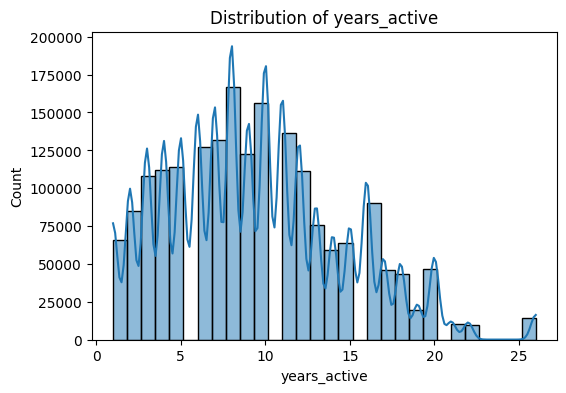

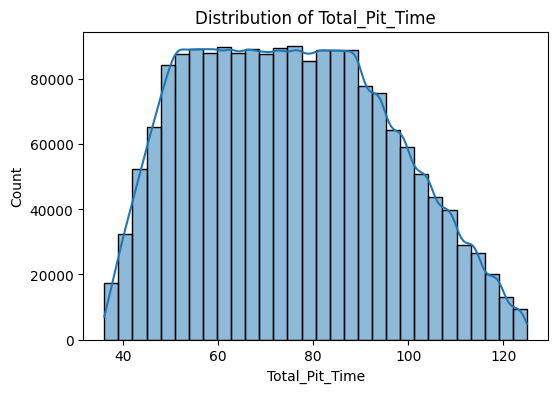

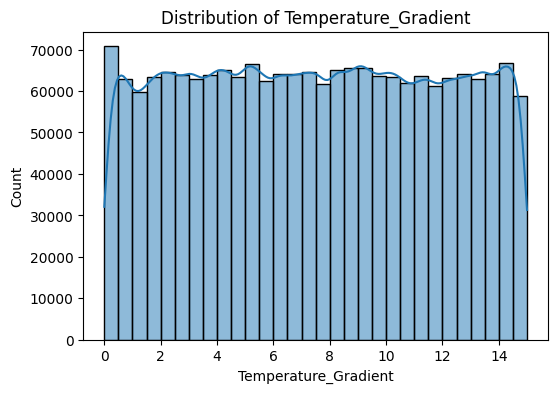

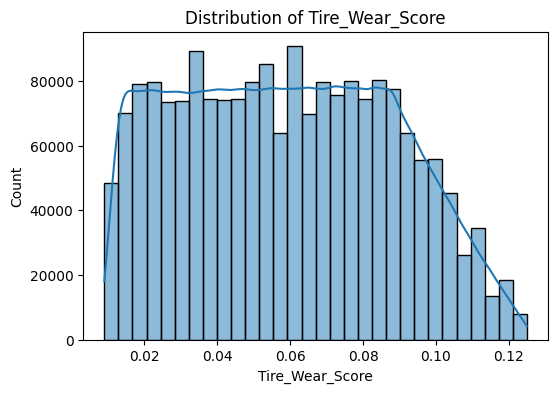

In [43]:
num_cols = [
    'Pit_Stop_Duration_Seconds', 'Ambient_Temperature_Celsius',
    'Track_Temperature_Celsius', 'Tire_Degradation_Factor_per_Lap',
    'Corners_per_Lap', 'starts', 'finishes', 'podiums', 'wins',
    'years_active', 'Total_Pit_Time', 'Temperature_Gradient',
    'Tire_Wear_Score'
]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


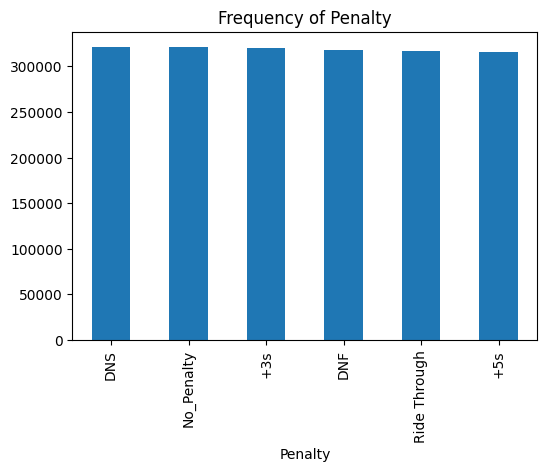

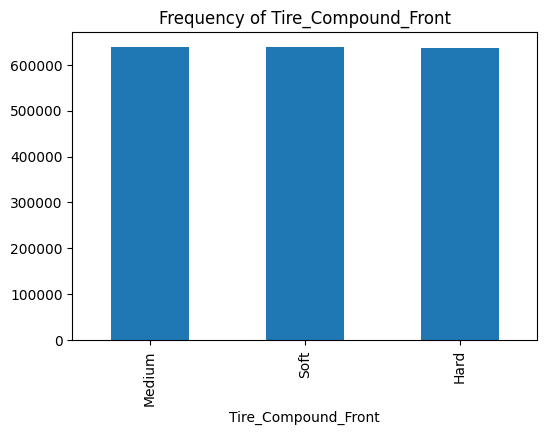

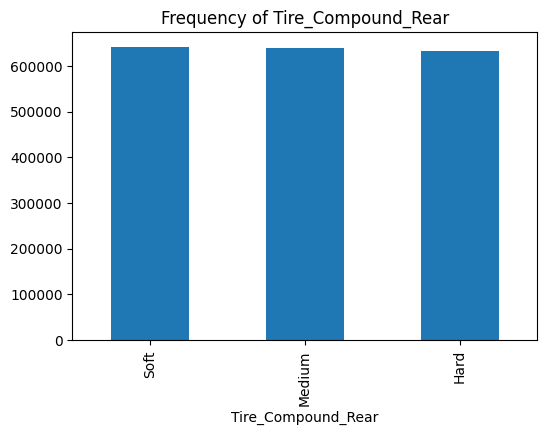

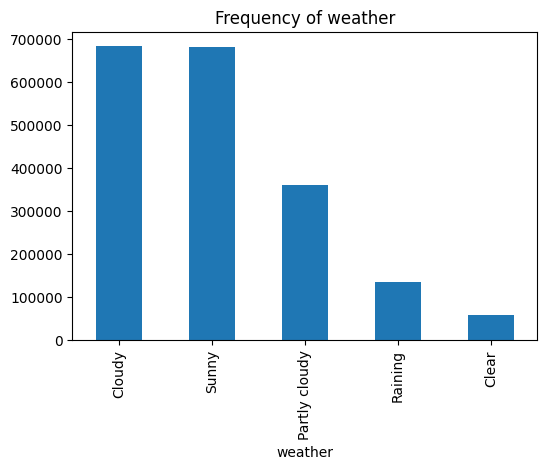

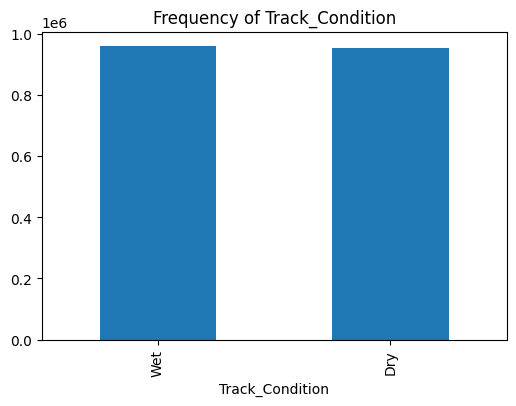

In [44]:
cat_cols = ['Penalty', 'Tire_Compound_Front', 'Tire_Compound_Rear', 'weather', 'Track_Condition']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Frequency of {col}')
    plt.show()


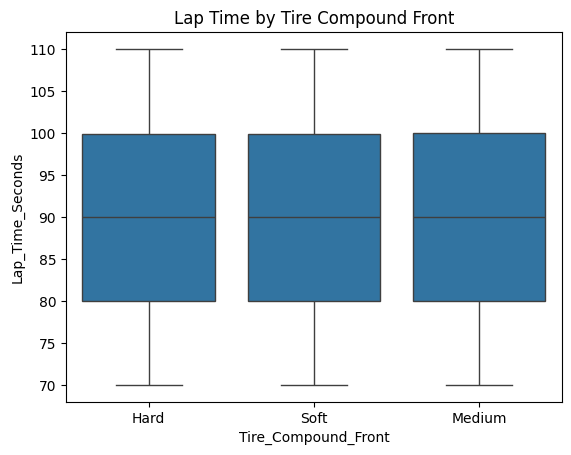

In [37]:
sns.boxplot(x='Tire_Compound_Front', y='Lap_Time_Seconds', data=df)
plt.title("Lap Time by Tire Compound Front")
plt.show()

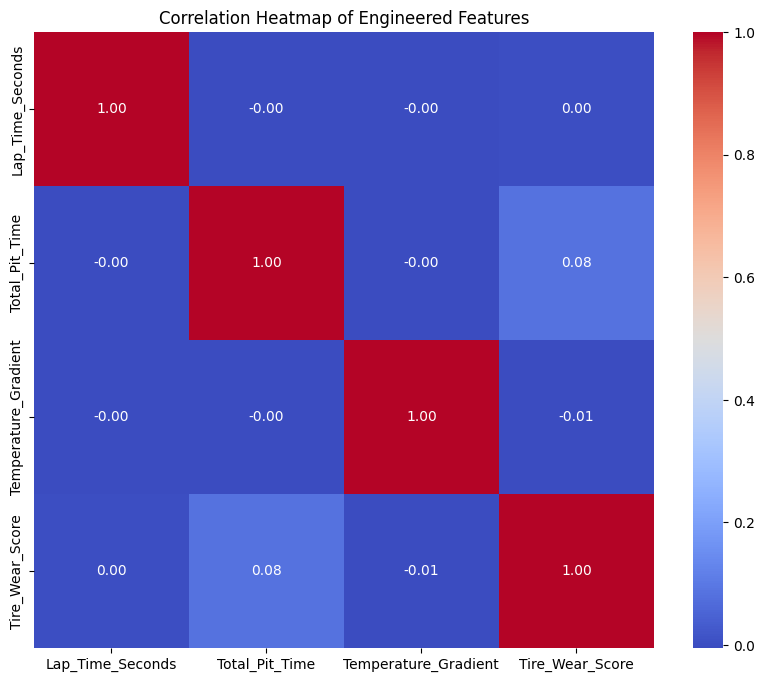

In [46]:
import numpy as np

plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Engineered Features")
plt.show()


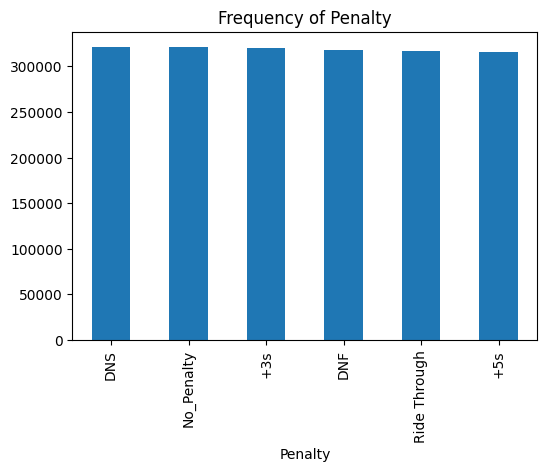

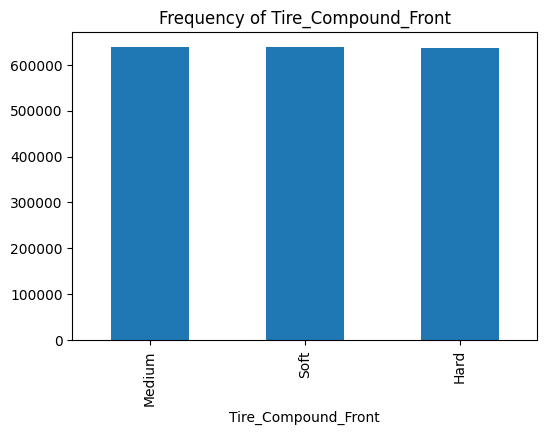

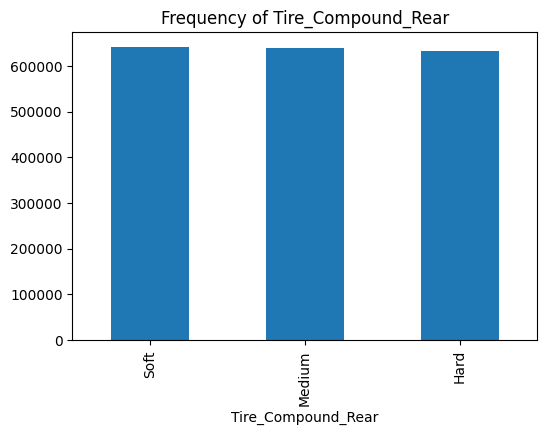

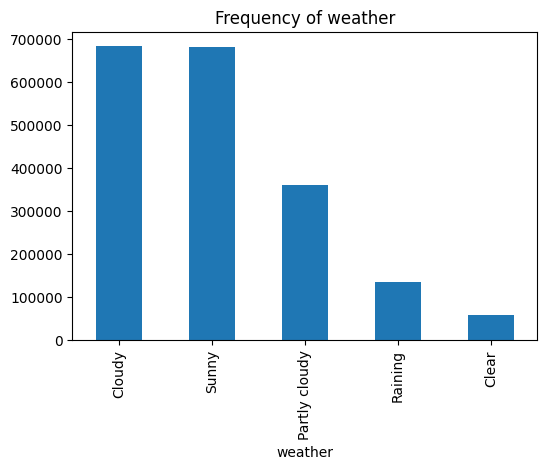

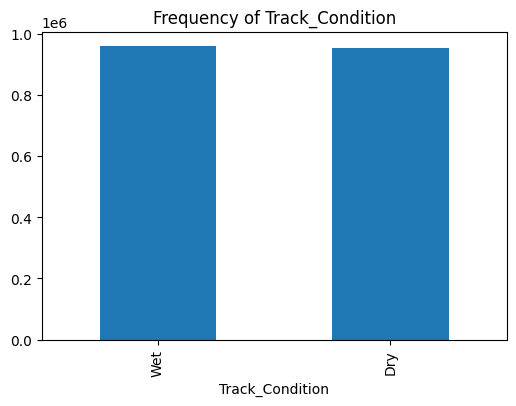

In [47]:
cat_cols = ['Penalty', 'Tire_Compound_Front', 'Tire_Compound_Rear', 'weather', 'Track_Condition']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Frequency of {col}')
    plt.show()


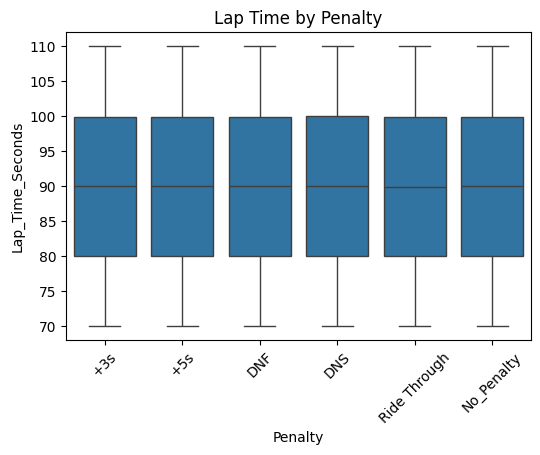

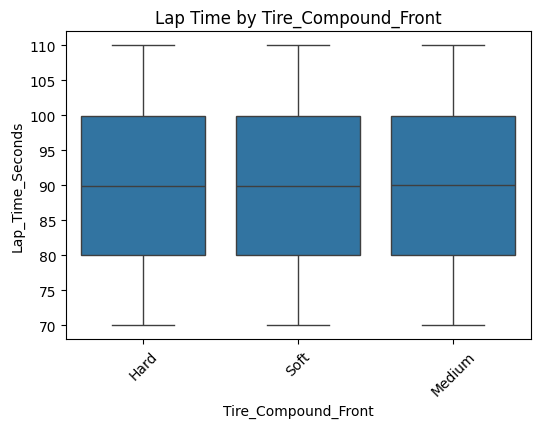

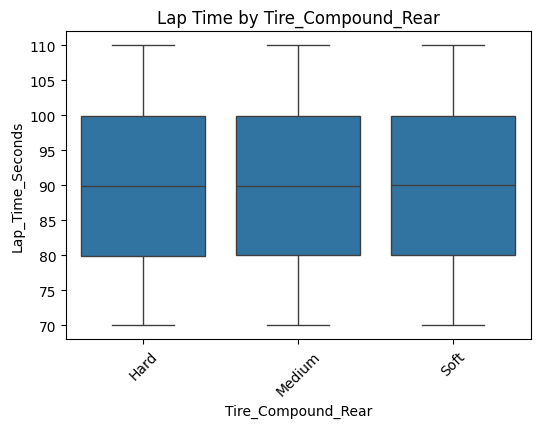

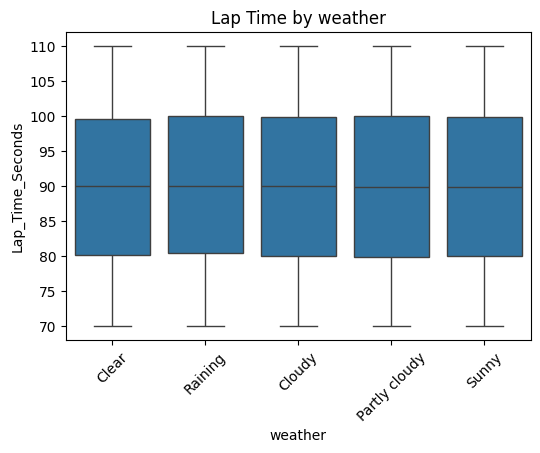

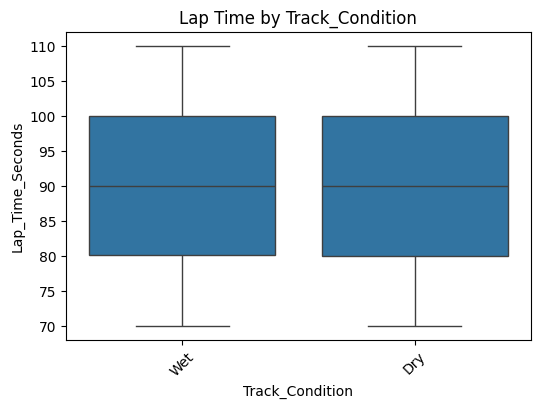

In [48]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, y='Lap_Time_Seconds', data=df)
    plt.title(f'Lap Time by {col}')
    plt.xticks(rotation=45)
    plt.show()


# **ML Model Implemntation**

***Tain-test-Split***

In [49]:
features = [
    'Pit_Stop_Duration_Seconds', 'Track_Temperature_Celsius', 'Ambient_Temperature_Celsius',
    'Tire_Degradation_Factor_per_Lap', 'Corners_per_Lap', 'Bike_Target_Lap', 'starts', 'Team_Target_Lap',
    'with_points', 'air', 'finishes', 'podiums', 'years_active', 'ground', 'wins', 'Weather_Risk',
    'Total_Pit_Time', 'Temperature_Gradient', 'Tire_Wear_Score'
]

X = df[features]
y = df['Lap_Time_Seconds']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=700,
    max_depth=7,
    learning_rate=0.2,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

In [52]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"XGBoost RMSE: {rmse:.4f}")

XGBoost RMSE: 4.7925


***Got the RSME: 4.7925***

# **Checking for overfitting**

In [54]:
# comparing actual vs predictions
check_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred
})
print(check_df.sample(10))


          Actual   Predicted
158996   107.317  102.649467
1245592   76.539   86.410149
1860573   98.428   94.198753
1800443   91.490   90.723289
444827    71.348   83.133492
1358284   83.890   87.081741
1893232   72.190   80.943459
535407    91.257   90.937141
301036    78.089   83.220322
486964    89.424   89.384239


***Seems good, not too much of difference is found harldy ~10 differene is there***

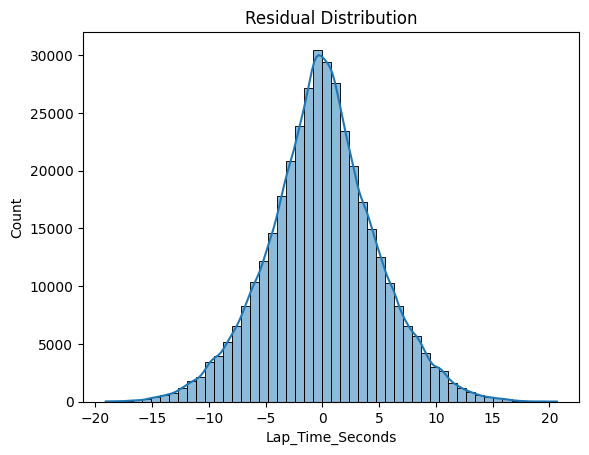

In [55]:
residuals = y_val - y_pred
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.show()


***Distribution seems symmetric and can be said that no overfitting is there***

# **Creating Submission File**

In [56]:
df_test = pd.read_csv("/content/burnout-datathon-ieeecsmuj/test.csv")

In [57]:
# Feature engineering for test data

# 1️⃣ Fill missing penalty
df_test['Penalty'].fillna("No_Penalty", inplace=True)

# 2️⃣ Binary flags
df_test["Penalty_Has_Time"] = df_test["Penalty"].isin(["+3s", "+5s"]).astype(int)
df_test["Penalty_RideThrough"] = (df_test["Penalty"] == "Ride Through").astype(int)
df_test["Penalty_DNF_DNS"] = df_test["Penalty"].isin(["DNF", "DNS"]).astype(int)

# 3️⃣ Tire front / rear mapping
tire_map = {'Hard': 1, 'Medium': 2, 'Soft': 3}
df_test['Tire_Compound_Front_Num'] = df_test['Tire_Compound_Front'].map(tire_map)
df_test['Tire_Compound_Rear_Num'] = df_test['Tire_Compound_Rear'].map(tire_map)

# 4️⃣ Track condition + weather
df_test['Is_Wet_Track'] = (df_test['Track_Condition'] == 'Wet').astype(int)

weather_map = {'Raining': 3, 'Cloudy': 2, 'Partly cloudy': 1, 'Clear': 0, 'Sunny': 0}
df_test['Weather_Risk'] = df_test['weather'].map(weather_map)

df_test['Is_Bad_Weather'] = ((df_test['Weather_Risk'] >= 2) | (df_test['Is_Wet_Track'] == 1)).astype(int)

# 5️⃣ Bike + team target encoding — use SAME mapping as train!
df_test['Bike_Target_Lap'] = df_test['bike_name'].map(bike_target)
df_test['Team_Target_Lap'] = df_test['team_name'].map(team_target)

# If any bike/team not seen in train
df_test['Bike_Target_Lap'].fillna(df['Lap_Time_Seconds'].mean(), inplace=True)
df_test['Team_Target_Lap'].fillna(df['Lap_Time_Seconds'].mean(), inplace=True)

# 6️⃣ Advanced feature engineering
df_test['Total_Pit_Time'] = df_test['Pit_Stop_Duration_Seconds'] * df_test['Laps']
df_test['Temperature_Gradient'] = df_test['Track_Temperature_Celsius'] - df_test['Ambient_Temperature_Celsius']
df_test['Tire_Wear_Score'] = df_test['Tire_Degradation_Factor_per_Lap'] * df_test['Laps']


In [58]:
# Predict on test data
y_pred_test = xgb.predict(df_test[features])


In [59]:
submission = pd.DataFrame({
    'Unique ID': df_test['Unique ID'],
    'Lap_Time_Seconds': y_pred_test
})

submission.to_csv('submission.csv', index=False)

## 🚀 Final Remarks
- XGBoost achieved a validation RMSE of ~4.79.
- Residuals distribution was symmetric — no major bias detected.
- Feature engineering contributed to model performance.


